# Gamma Matrix Estimation

In this notebook, I am going to use the pyGSTi data to estimate the response matrix for measurement process. 

## I. Introduction of Background Knowledge
The $\Gamma$ matrix here in our discussion is a kind of response matrix without the state-preparation error. In general calibration experiment, we need to prepare every possible basis state for $n$ qubits experiment, and measure the output result with different input basis state. Based on the measurement result, we can define the response matrix $A$, 
\begin{equation}
p_{\rm exp} = Ap_{\rm ideal}
\end{equation}
where $p_{\rm exp}$ and $p_{\rm ideal}$ are the probability of each basis state from experiment and theory, respectively. The element of response matrix $A$ is given by
\begin{equation}
a_{ij} = Pr(\text{measure }i|\text{true }j)
\end{equation}

However, the initial state is not precisely prepared as expected, so from the final measurement we will obtain a response matrix with state-preparation error. Namely, the element of $A$ matrix is not precisely $Pr(\text{measure }i|\text{true }j)$. To consider the state-preparation error, Michael Geller purposes a method using gate-set tomography (GST) to estimate $Pr(\text{measure }i|\text{true }j)$. (see here: [Conditionally rigorous mitigation of multiqubit measurement errors](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.127.090502)). We call the response matrix estimated from GST techniques $\Gamma$ matrix to distinguish the response matrix $A$ obtained from traditional calibration experiment. The estimation for one qubit will mainly follow the procedure below:

- Perform calibration experiment
    - Prepare $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|\psi\rangle = SH|0\rangle$ for one qubit
    - Get the measurement result for every qubit
- Perform GST experiment
- Estimate the $\Gamma$ matrix
    - Estimate noisy state $\rho_0$, $\rho_1$, $\rho_{+}$ and $\rho_{+i}$ via GST experiment result
    - Estimatie $L$ matrix from noisy state and noisy $G_{x}$ and $G_{y}$ gate
    - Estimate the $\Gamma$ matrix via $L$ matrix

In the following sections, I will provide details of the third step. Please refer to other notebook for details about the first, second and last step. 

In [1]:
# Import require package
import numpy as np
from qiskit import IBMQ
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

## II. The Procedure of $\Gamma$ Matrix Estimation
In this section, I will describe details of how to finish 4 steps of $\Gamma$ matrix estimation. 

### A. Perform Calibration Experiment
The calibration experiment is used to collect required data from the device to estimate the bias of measurement. Rather than only measure the output of initial state $|0\rangle$ and $|1\rangle$, here we need to get the result for the following four single-qubit state, 

\begin{equation}
|0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}, 
|1\rangle = \begin{pmatrix} 0 \\ 1 \end{pmatrix}, 
|+\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix},
|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ i \end{pmatrix}
\end{equation}

The output of prepare these four state for qubit 0 is given below, and the application of calibration result is in SectionII.C.3. Note that both state-preparation error and readout error are included in the result. For details about how to construct the calibration experiment, please refer to other notebook 

In [2]:
# Calibration result
try_zero_result = {'get-zero': 994, 'get-one': 6}
try_one_result = {'get-zero': 34, 'get-one': 966}
try_plus_result = {'get-zero': 496, 'get-one': 504}
try_psi_result = {'get-zero': 505, 'get-one': 495}

\begin{equation}
(L^{-1})_{00}{\rm tr}\left(E_{0}\rho_{0}\right) + (L^{-1})_{01}{\rm tr}\left(E_{0} \rho_{1}\right) + (L^{-1})_{0+}{\rm tr}\left(E_{0}\rho_{+}\right) + (L^{-1})_{0(+i)} {\rm tr}\left( E_{0}\rho_{(+i)} \right)
\end{equation}

In [3]:
# Calibration
def getCaliResult(try_result, shot = 1000):
    try_zero_result = try_result[0]
    try_one_result = try_result[1]
    try_plus_result = try_result[2]
    try_psi_result = try_result[3]
    
    getZero = np.array([try_zero_result['get-zero']/shot, try_one_result['get-zero']/shot, 
                   try_plus_result['get-zero']/shot, try_psi_result['get-zero']/shot])
    getOne = np.array([try_zero_result['get-one']/shot, try_one_result['get-one']/shot, 
                  try_plus_result['get-one']/shot, try_psi_result['get-one']/shot])
    
    return [getZero, getOne]

getZero, getOne = getCaliResult([try_zero_result, try_one_result, try_plus_result,try_psi_result])

### B. Perform GST Experiment
The GST experiment is used to collect required data from the device to estimate the noisy prepared state. Please refer to other notebook for details. 

### C. Estimate $\Gamma$ Matrix
In this section, I will use the calibration and GST result to estimate the $\Gamma$ matrix. For illustration, I will focus only on qubit 0 of quantum device ibmq\_lima as an example. 

#### 1. Estimate Noisy State
In this section I will provide details on how to get the noisy state $\{\rho_0, \rho_1, \rho_+, \rho_{+i}\}$ for further calculation. Here I summarize three steps below to avoid confusion, 

* **Step 1**: Calculate $|\rho_0\rangle\rangle$
* **Step 2**: Use $|\rho_0\rangle\rangle$ and noisy gate $G_x$ and $G_y$ to get $|\rho_1\rangle\rangle$, $|\rho_+\rangle\rangle$ and $|\rho_{+i}\rangle\rangle$
* **Step 3**: Get noisy state $\rho_{1}, \rho_{+}, \rho_{+i}$ from $|\rho_1\rangle\rangle$, $|\rho_+\rangle\rangle$ and $|\rho_{+i}\rangle\rangle$

Now let's begin our estimation of noisy state with state-preparation error. As in Section II.A, we need to prepare four single-qubit state $|0\rangle, |1\rangle, |+\rangle, |\psi\rangle$, which correspond to the density matrix
\begin{equation}
\pi_0 = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}, 
\pi_1 = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix}, 
\pi_{+} = \frac{1}{2}\begin{pmatrix} 1 & 1\\ 1 & 1 \end{pmatrix},
\pi_{+1} = \frac{1}{2}\begin{pmatrix} 1 & -i\\ i & 1 \end{pmatrix}
\end{equation}

Due to the presence of state-preparation error, instead of preparing $\{\pi_0, \pi_1, \pi_+, \pi_{+i}\}$, we will prepare a set of noisy state $\{\rho_0, \rho_1, \rho_+, \rho_{+i}\}$. The noisy $\rho_0$ can be directly obtained from GST experiment result, while the other three noisy state can only be estimated by noisy gate $G_{x}$ and $G_y$, with their noise-free form as

\begin{equation}
G_{x} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & -1 \\
0 & 0 & 1 & 0 \\
\end{pmatrix}, G_{y} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & -1 & 0 & 0 \\
\end{pmatrix}
\end{equation}

The noisy $\rho_0$, $G_{x}$ and $G_y$ result from GST experiment is shown below. Note that the result here will only include the state-preparation error. 

In [4]:
# Noisy state rho0
rho0 = np.array([[0.9945645, -0.0085467],
                 [-0.0269976, 0.0054355]])

# Noisy gate Gx
Gx = np.array([[1, 0, 0, 0], 
               [0.0003134, 0.9975053, 0.0070664, 0.0061008], 
               [-0.003582, 0.0017868, -0.0002412, -0.9982639], 
               [0.0199663, -0.0008216, 0.9994638, 0.0049076]])

# Noisy gate Gy
Gy = np.array([[1, 0, 0, 0], 
               [-0.0035356, -0.0031584, 0.0092401, 0.9983456], 
               [0.0001654, 0.0035338, 0.9994461, 0.0013525], 
               [0.0113752, -0.9985736, 0.0043543, 0.0006209]])

To continue our calculation, we need to introduce a special kind of vector, $|\rho_{\lambda}\rangle\rangle$, which is used in GST analysis. For an arbitrary state $\rho$,
\begin{equation}
\rho = \begin{pmatrix}
a & b \\ c & d
\end{pmatrix}
\end{equation}

its corresponding GST vector $|\rho_{\lambda}\rangle\rangle$ is defined via the Pauli basis, 

\begin{equation}
|\rho_{\lambda}\rangle\rangle_{\sigma} = \frac{{\rm tr}(\rho_{\lambda} \sigma)}{2} \iff 
\begin{cases}
|\rho_{\lambda}\rangle\rangle_{I} = {\rm tr}(\rho_{\lambda}I)/2 \\
|\rho_{\lambda}\rangle\rangle_{X} = {\rm tr}(\rho_{\lambda}X)/2 \\
|\rho_{\lambda}\rangle\rangle_{Y} = {\rm tr}(\rho_{\lambda}Y)/2 \\
|\rho_{\lambda}\rangle\rangle_{Z} = {\rm tr}(\rho_{\lambda}Z)/2 \\
\end{cases}
\end{equation}we can calculate the four components of $|\rho_{\lambda}\rangle\rangle$ from

\begin{equation}
\rho_{\lambda}I = \begin{pmatrix}
a & b \\ c & d
\end{pmatrix}\begin{pmatrix}
1 & 0 \\ 0 & 1
\end{pmatrix} = \begin{pmatrix}
a & b \\ c & d
\end{pmatrix}, 
\rho_{\lambda}X = \begin{pmatrix}
a & b \\ c & d
\end{pmatrix}\begin{pmatrix}
0 & 1 \\ 1 & 0
\end{pmatrix} = \begin{pmatrix}
b & a  \\ d & c
\end{pmatrix}\\
\rho_{\lambda}Y = \begin{pmatrix}
a & b \\ c & d
\end{pmatrix}\begin{pmatrix}
0 & -i \\ i & 0
\end{pmatrix} = \begin{pmatrix}
bi & -ai  \\ di & -ci
\end{pmatrix}, 
\rho_{\lambda}Z = \begin{pmatrix}
a & b \\ c & d
\end{pmatrix}\begin{pmatrix}
1 & 0 \\ 0 & -1
\end{pmatrix} = \begin{pmatrix}
a & -b \\ c & -d
\end{pmatrix}
\end{equation}

Therefore, $|\rho_{\lambda}\rangle\rangle$ is given by

\begin{equation}
|\rho_{\lambda}\rangle\rangle = \frac{1}{2}\begin{pmatrix}
a+d \\
b+c \\
(b-c)i \\
a-d \\
\end{pmatrix}
\end{equation}

Below I define a function `getGSTVector` to get $|\rho_{\lambda}\rangle\rangle$ from given $\rho_{\lambda}$. Note that `getGSTVector` is only for getting $|\rho_0\rangle\rangle$ from $\rho_0$, and this is our **Step 1**. 

In [5]:
# Step 1
def getGSTVector(state):
    '''
    Define the function to calculate |rho>> from density matrix rho
    '''
    a = state[0][0]
    b = state[0][1]
    c = state[1][0]
    d = state[1][1]
    return 0.5*np.array([a+d, b+c, (b-c)*1j, a-d])

# Calculate |rho_0>>
rho0_GST = getGSTVector(rho0)

After getting $|\rho_0\rangle\rangle$, we can get the other three noisy states by following ways, 

\begin{align}
|\rho_{1}\rangle\rangle = G_{x}^{2} |\rho_{0}\rangle\rangle  \\
|\rho_{+}\rangle\rangle = G_{y} |\rho_{0}\rangle\rangle \\
|\rho_{+i}\rangle\rangle = G_{x}^{3} |\rho_{0}\rangle\rangle  \\
\end{align}

and this is our **Step 2**. 

In [6]:
# Step 2
Gx2 = np.matmul(Gx, Gx)
Gx3 = np.matmul(Gx2, Gx)

rho1_GST = np.matmul(Gx2, rho0_GST)
rhop_GST = np.matmul(Gy, rho0_GST)
rhoi_GST = np.matmul(Gx3, rho0_GST)

After getting $|\rho_{1}\rangle\rangle, |\rho_{+}\rangle\rangle, |\rho_{+i}\rangle\rangle$, we can convert the GST vector into density matrix, and this is our **Step 3**. Since for a arbitrary density matrix $\rho_{\lambda}$, $|\rho_{\lambda}\rangle\rangle$ is given by

\begin{equation}
|\rho_{\lambda}\rangle\rangle = \begin{pmatrix}
|\rho_{\lambda}\rangle\rangle_{I} \\
|\rho_{\lambda}\rangle\rangle_{X} \\
|\rho_{\lambda}\rangle\rangle_{Y} \\
|\rho_{\lambda}\rangle\rangle_{Z} \\
\end{pmatrix} =
\frac{1}{2}\begin{pmatrix}
a+d \\
b+c \\
(b-c)i \\
a-d \\
\end{pmatrix}
\end{equation}

We can solve the equation and get

\begin{align}
a &= |\rho_{\lambda}\rangle\rangle_I + |\rho_{\lambda}\rangle\rangle_Z \\
b &= |\rho_{\lambda}\rangle\rangle_X - i|\rho_{\lambda}\rangle\rangle_Y\\
c &= |\rho_{\lambda}\rangle\rangle_X + i|\rho_{\lambda}\rangle\rangle_Y\\
d &= |\rho_{\lambda}\rangle\rangle_I - |\rho_{\lambda}\rangle\rangle_Z
\end{align}

Below I define a function `getDenOper` to get $\rho_{\lambda}$ from given $\rho_{\lambda}$. 

In [7]:
def getDenOper(GSTVector):
    rhoI = GSTVector[0]
    rhoX = GSTVector[1]
    rhoY = GSTVector[2]
    rhoZ = GSTVector[3]
    return np.array([[rhoI+rhoZ, rhoX-rhoY*1j], 
                     [rhoX+rhoY*1j, rhoI-rhoZ]])

In [8]:
rho1 = getDenOper(rho1_GST)
rhop = getDenOper(rhop_GST)
rhoi = getDenOper(rhoi_GST)

#### 2. Estimate $L$ Matrix

We can estimate the $L$ matrix with all required noisy state $\rho_{0}, \rho_{1}, \rho{+}, \rho_{+i}$. The $L$ matrix is defined by

\begin{align}
\rho_{\lambda} &= \sum_{\lambda' \in \{0, 1, +, +i\}}L_{\lambda\lambda'}\pi_{\lambda'}\\
&= L_{\lambda0}\pi_{0} + L_{\lambda1}\pi_{1} 
+ L_{\lambda+}\pi_{+} + L_{\lambda(+i)}\pi_{+i}
\end{align}

According to the paper, any single-qubit state $\rho$ can be written as a unique combination of $\{\pi_0, \pi_1, \pi_+, \pi_{+i}\}$ with Bloch vector $\vec{r} = (x,y,z)$. For an arbitrary state, we can re-write its density matrix with the Bloch vector,

\begin{equation}
\rho = \begin{pmatrix}
a & b \\ c & d
\end{pmatrix} = \frac{1}{2}\begin{pmatrix}
1+z & x-iy \\ x+iy & 1-z
\end{pmatrix}
\end{equation}
Equivalently, the elements of Bloch vector is given by
\begin{equation}
x = b+c, \,y=(b-c)i,\, z = 2a-1 = 1-2d, \,x,y,z\in\mathbb{R}
\end{equation}

Since a noisy state can be written in the form, 
\begin{equation}
\rho_{\lambda} = \left(\frac{1-x-y+z}{2}\right)\pi_0 + \left(\frac{1-x-y-z}{2}\right)\pi_1 
+ x\pi_{+} + y\pi_{+i}
\end{equation}
We can conclude that the elements of $L$ matrix are then given by

\begin{equation}
L_{\lambda0}= \frac{1-x-y+z}{2}, L_{\lambda1} = \frac{1-x-y-z}{2}, L_{\lambda+} = x, L_{\lambda(+i)}=y
\end{equation}

Below I define a function `getLMatrix` to get $L$ from given noisy state $\rho_{\lambda}$. 

In [9]:
def getLMatrix(noisy_state):
    """
    Calculate the L Matrix from 4 noisy density operator
    """
    if len(noisy_state) != 4:
        return np.nan
    
    L = np.ones((4, 4))
    for i in range(len(noisy_state)):
        state = noisy_state[i]
        a = state[0][0]
        b = state[0][1]
        c = state[1][0]
        d = state[1][1]
        
        x = b+c
        y = (b-c)*1j
        z = 2*a - 1
        
        L[i] = np.array([0.5*(1-x-y+z), 0.5*(1-x-y-z), x, y])
    
    return L

In [10]:
matrixL = getLMatrix([rho0, rho1, rhop, rhoi])
matrixL

/tmp/ipykernel_351/1217648530.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  L[i] = np.array([0.5*(1-x-y+z), 0.5*(1-x-y-z), x, y])


array([[ 1.01233665,  0.02320765, -0.0355443 ,  0.        ],
       [ 0.0466806 ,  1.01709431, -0.03557334, -0.02820158],
       [ 0.03101806, -0.01646489,  0.98406925,  0.00137759],
       [ 0.03162361,  0.04457695, -0.04129078,  0.96509022]])

#### 3. Estimate $\Gamma$ Matrix

With all preparation, we can calculate $\Gamma$ matrix from $L$ matrix and calibration result. For a single qubit, the $\Gamma$ matrix is given by 

\begin{equation}
\Gamma = \begin{pmatrix}
Pr(\text{measure }0|\text{true }0) & Pr(\text{measure }0|\text{true }1) \\
Pr(\text{measure }1|\text{true }0) & Pr(\text{measure }1|\text{true }1)
\end{pmatrix}
\end{equation}
where each element does not have state-preparation noise and is the result of noisy POVM measurement. Thus, the probability above can be estimated by
\begin{align}
\Gamma_{11} = Pr(\text{measure }0|\text{true }0) = {\rm tr}(E_{0}|0\rangle\langle 0|) \\
\Gamma_{12} = Pr(\text{measure }0|\text{true }1) = {\rm tr}(E_{0}|1\rangle\langle 1|) \\
\Gamma_{21} = Pr(\text{measure }1|\text{true }0) = {\rm tr}(E_{1}|0\rangle\langle 0|) \\
\Gamma_{22} = Pr(\text{measure }1|\text{true }1) = {\rm tr}(E_{1}|1\rangle\langle 1|) 
\end{align}
where $E_0$ is the noisy measurement of POVM operator $|0\rangle\langle 0|$, and $E_1$ is the noisy measurement of POVM operator $|1\rangle\langle 1|$.

Note that 
\begin{align}
\pi_{\lambda} &= \sum_{\lambda' \in \{0, 1, +, +i\}}(L^{-1})_{\lambda\lambda'}\rho_{\lambda'}\\
&= (L^{-1})_{\lambda0}\rho_{0} + (L^{-1})_{\lambda1}\rho_{1} 
+ (L^{-1})_{\lambda+}\rho_{+} + (L^{-1})_{\lambda(+i)}\rho_{+i}
\end{align}
and $\pi_0 = |0\rangle\langle 0|$, the element $\Gamma_11$ matrix is given by
\begin{align}
\Gamma_{11} &= {\rm tr}(E_{0}|0\rangle\langle 0|) \\
            &= {\rm tr}\left(E_{0} \sum_{\lambda' \in \{0, 1, +, +i\}}(L^{-1})_{\lambda\lambda'}\rho_{\lambda'}\right)\\
            &= {\rm tr}\left\{E_{0} \left[(L^{-1})_{00}\rho_{0} + (L^{-1})_{01}\rho_{1} + (L^{-1})_{0+}\rho_{+} + (L^{-1})_{0(+i)}\rho_{(+i)}\right]\right\} \\
            &= {\rm tr}\left[E_{0} (L^{-1})_{00}\rho_{0}\right] + {\rm tr}\left[E_{0} (L^{-1})_{01}\rho_{1}\right] + {\rm tr}\left[E_{0} (L^{-1})_{0+}\rho_{+}\right] + {\rm tr}\left[E_{0} (L^{-1})_{0(+1)}\rho_{(+1)}\right] \\
            &= (L^{-1})_{00}{\rm tr}\left(E_{0}\rho_{0}\right) + (L^{-1})_{01}{\rm tr}\left(E_{0} \rho_{1}\right) + (L^{-1})_{0+}{\rm tr}\left(E_{0}\rho_{+}\right) + (L^{-1})_{0(+i)} {\rm tr}\left( E_{0}\rho_{(+i)} \right)\\
\end{align}
where $L^{-1}$ can be estimated from inverse of $L$ matrix, and ${\rm tr}(E_0\rho_{\lambda})$ is estimated from the calibration experiment, 

* ${\rm tr}\left(E_{0}\rho_{0}\right)$ is the measurement of $0$ for noisy state $\rho_0$ (try to prepare $|0\rangle$)
* ${\rm tr}\left(E_{0}\rho_{1}\right)$ is the measurement of $0$ for noisy state $\rho_1$ (try to prepare $|1\rangle$)
* ${\rm tr}\left(E_{0}\rho_{+}\right)$ is the measurement of $0$ for noisy state $\rho_{+}$ (try to prepare $|+\rangle$)
* ${\rm tr}\left(E_{0}\rho_{+i}\right)$ is the measurement of $0$ for noisy state $\rho_{+i}$ (try to prepare $|\psi\rangle$)

Similarly, the other three elements can be calculated by
\begin{align}
\Gamma_{12} &= {\rm tr}(E_{0}|1\rangle\langle 1|) = (L^{-1})_{10}{\rm tr}\left(E_{0}\rho_{0}\right) + (L^{-1})_{11}{\rm tr}\left(E_{0} \rho_{1}\right) + (L^{-1})_{1+}{\rm tr}\left(E_{0}\rho_{+}\right) + (L^{-1})_{1(+i)} {\rm tr}\left( E_{0}\rho_{(+i)} \right)\\
\Gamma_{21} &= {\rm tr}(E_{1}|0\rangle\langle 0|) = (L^{-1})_{00}{\rm tr}\left(E_{1}\rho_{0}\right) + (L^{-1})_{01}{\rm tr}\left(E_{1} \rho_{1}\right) + (L^{-1})_{0+}{\rm tr}\left(E_{1}\rho_{+}\right) + (L^{-1})_{0(+i)} {\rm tr}\left( E_{1}\rho_{(+i)} \right)\\
\Gamma_{22} &= {\rm tr}(E_{1}|1\rangle\langle 1|) = (L^{-1})_{10}{\rm tr}\left(E_{1}\rho_{0}\right) + (L^{-1})_{11}{\rm tr}\left(E_{1} \rho_{1}\right) + (L^{-1})_{1+}{\rm tr}\left(E_{1}\rho_{+}\right) + (L^{-1})_{1(+i)} {\rm tr}\left( E_{1}\rho_{(+i)} \right)\\\\
\end{align}

In [11]:
def getGammaMatrix(matrixL, getZero, getOne):
    """
    Calculate the Gamma Matrix from 4 noisy density operator
    """
    gamma = np.ones((2, 2))
    L0 = matrixL[0]
    L1 = matrixL[1]
    # gamma_11
    gamma[0][0] = np.dot(L0, getZero)
    # gamma_12
    gamma[0][1] = np.dot(L1, getZero)
    # gamma_21
    gamma[1][0] = np.dot(L0, getOne)
    # gamma_22
    gamma[1][1] = np.dot(L1, getOne)
    return gamma

In [12]:
gamma0 = getGammaMatrix(matrixL, getZero, getOne)

In conclusion, we would need several steps and details to get $\Gamma$ matrix for a single qubit. I will summarize details of each step here again for reference:

* **Preparation**: Run GST experiment and get noisy state $\rho_0$, noisy gate $G_x$ and $G_y$
* **Step 1**: Calculate $|\rho_0\rangle\rangle$
* **Step 2**: Use $|\rho_0\rangle\rangle$ and noisy gate $G_x$ and $G_y$ to get $|\rho_1\rangle\rangle$, $|\rho_+\rangle\rangle$ and $|\rho_{+i}\rangle\rangle$
* **Step 3**: Get noisy state $\rho_{1}, \rho_{+}, \rho_{+i}$ from $|\rho_1\rangle\rangle$, $|\rho_+\rangle\rangle$ and $|\rho_{+i}\rangle\rangle$
* **Step 4**: Get $L$ matrix from noisy state from $\rho_{0}, \rho_{1}, \rho_{+}, \rho_{+i}$
* **Step 5**: Get $\Gamma$ matrix from $L$ matrix and calibration result. 

## III. Gamma Matrix of Multiple Qubit
Above we have obtained the $\Gamma$ matrix for a single qubit. We can in principle get $\Gamma$ matrix for $5$ qubits directly, here for simplicity (and also consistent with the work of Geller's paper), we consider a tensor product version of $\Gamma$ matrix, 
\begin{equation}
\Gamma = \Gamma_0\otimes \Gamma_1 \otimes \cdots \otimes \Gamma_n 
= \bigotimes_{i=0}^{n}\Gamma_i = \bigotimes_{i=0}^{n}\Gamma_i 
\end{equation}

Below I will repeat all above processes and obtain the gamma matrix for all $5$ qubits.

### A. Qubit 1
For Qubit 1, below is the updated experiment result for state-preparation and GST experiment. 

In [13]:
# Qubit 1
try_zero_result = {'get-zero': 992, 'get-one': 8}
try_one_result = {'get-zero': 96, 'get-one': 904}
try_plus_result = {'get-zero': 548, 'get-one': 452}
try_psi_result = {'get-zero': 536, 'get-one': 464}

# Noisy state rho0
rho0 = np.array([[0.9968314, 0.0174616],
                 [0.0135767, 0.0031866]])

# Noisy gate Gx
Gx = np.array([[1, 0, 0, 0], 
               [0.0003134, 0.9975053, 0.0070664, 0.0061008], 
               [-0.003582, 0.0017868, -0.0002412, -0.9982639], 
               [0.0199663, -0.0008216, 0.9994638, 0.0049076]])

# Noisy gate Gy
Gy = np.array([[1, 0, 0, 0], 
               [-0.0035356, -0.0031584, 0.0092401, 0.9983456], 
               [0.0001654, 0.0035338, 0.9994461, 0.0013525], 
               [0.0113752, -0.9985736, 0.0043543, 0.0006209]])

Following the given $5$ steps, we can obtain $\Gamma$ matrix for Qubit 1. 

In [14]:
getZero, getOne = getCaliResult([try_zero_result, try_one_result, try_plus_result,try_psi_result])

# Step 1
rho0_GST = getGSTVector(rho0)

# Step 2
Gx2 = np.matmul(Gx, Gx)
Gx3 = np.matmul(Gx2, Gx)

rho1_GST = np.matmul(Gx2, rho0_GST)
rhop_GST = np.matmul(Gy, rho0_GST)
rhoi_GST = np.matmul(Gx3, rho0_GST)

# Step 3
rho1 = getDenOper(rho1_GST)
rhop = getDenOper(rhop_GST)
rhoi = getDenOper(rhoi_GST)

# Step 4
matrixL = getLMatrix([rho0, rho1, rhop, rhoi])

# Step 5
gamma1 = getGammaMatrix(matrixL, getZero, getOne)

/tmp/ipykernel_351/1217648530.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  L[i] = np.array([0.5*(1-x-y+z), 0.5*(1-x-y-z), x, y])


### B. Qubit 2
For Qubit 2, below is the updated experiment result for state-preparation and GST experiment.

In [15]:
# Qubit 2
try_zero_result = {'get-zero': 992, 'get-one': 8}
try_one_result = {'get-zero': 26, 'get-one': 974}
try_plus_result = {'get-zero': 492, 'get-one': 508}
try_psi_result = {'get-zero': 521, 'get-one': 479}

# Noisy state rho0
rho0 = np.array([[0.9945645, -0.0085467],
                 [-0.0269976, 0.0054355]])

# Noisy gate Gx
Gx = np.array([[1, 0, 0, 0], 
               [0.0003134, 0.9975053, 0.0070664, 0.0061008], 
               [-0.003582, 0.0017868, -0.0002412, -0.9982639], 
               [0.0199663, -0.0008216, 0.9994638, 0.0049076]])

# Noisy gate Gy
Gy = np.array([[1, 0, 0, 0], 
               [-0.0035356, -0.0031584, 0.0092401, 0.9983456], 
               [0.0001654, 0.0035338, 0.9994461, 0.0013525], 
               [0.0113752, -0.9985736, 0.0043543, 0.0006209]])

Following the given $5$ steps, we can obtain $\Gamma$ matrix for Qubit 2. 

In [16]:
getZero, getOne = getCaliResult([try_zero_result, try_one_result, try_plus_result,try_psi_result])

# Step 1
rho0_GST = getGSTVector(rho0)

# Step 2
Gx2 = np.matmul(Gx, Gx)
Gx3 = np.matmul(Gx2, Gx)

rho1_GST = np.matmul(Gx2, rho0_GST)
rhop_GST = np.matmul(Gy, rho0_GST)
rhoi_GST = np.matmul(Gx3, rho0_GST)

# Step 3
rho1 = getDenOper(rho1_GST)
rhop = getDenOper(rhop_GST)
rhoi = getDenOper(rhoi_GST)

# Step 4
matrixL = getLMatrix([rho0, rho1, rhop, rhoi])

# Step 5
gamma2 = getGammaMatrix(matrixL, getZero, getOne)

/tmp/ipykernel_351/1217648530.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  L[i] = np.array([0.5*(1-x-y+z), 0.5*(1-x-y-z), x, y])


### C. Qubit 3
For Qubit 3, below is the updated experiment result for state-preparation and GST experiment.

In [17]:
# Qubit 3
try_zero_result = {'get-zero': 980, 'get-one': 20}
try_one_result = {'get-zero': 69, 'get-one': 931}
try_plus_result = {'get-zero': 470, 'get-one': 530}
try_psi_result = {'get-zero': 455, 'get-one': 545}

# Noisy state rho0
rho0 = np.array([[0.9945645, -0.0085467],
                 [-0.0269976, 0.0054355]])

# Noisy gate Gx
Gx = np.array([[1, 0, 0, 0], 
               [0.0003134, 0.9975053, 0.0070664, 0.0061008], 
               [-0.003582, 0.0017868, -0.0002412, -0.9982639], 
               [0.0199663, -0.0008216, 0.9994638, 0.0049076]])

# Noisy gate Gy
Gy = np.array([[1, 0, 0, 0], 
               [-0.0035356, -0.0031584, 0.0092401, 0.9983456], 
               [0.0001654, 0.0035338, 0.9994461, 0.0013525], 
               [0.0113752, -0.9985736, 0.0043543, 0.0006209]])

Following the given $5$ steps, we can obtain $\Gamma$ matrix for Qubit 3. 

In [18]:
getZero, getOne = getCaliResult([try_zero_result, try_one_result, try_plus_result,try_psi_result])

# Step 1
rho0_GST = getGSTVector(rho0)

# Step 2
Gx2 = np.matmul(Gx, Gx)
Gx3 = np.matmul(Gx2, Gx)

rho1_GST = np.matmul(Gx2, rho0_GST)
rhop_GST = np.matmul(Gy, rho0_GST)
rhoi_GST = np.matmul(Gx3, rho0_GST)

# Step 3
rho1 = getDenOper(rho1_GST)
rhop = getDenOper(rhop_GST)
rhoi = getDenOper(rhoi_GST)

# Step 4
matrixL = getLMatrix([rho0, rho1, rhop, rhoi])

# Step 5
gamma3 = getGammaMatrix(matrixL, getZero, getOne)

/tmp/ipykernel_351/1217648530.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  L[i] = np.array([0.5*(1-x-y+z), 0.5*(1-x-y-z), x, y])


### D. Qubit 4
For Qubit 4, below is the updated experiment result for state-preparation and GST experiment.

In [19]:
# Qubit 4
try_zero_result = {'get-zero': 991, 'get-one': 9}
try_one_result = {'get-zero': 106, 'get-one': 894}
try_plus_result = {'get-zero': 521, 'get-one': 479}
try_psi_result = {'get-zero': 549, 'get-one': 451}

# Noisy state rho0
rho0 = np.array([[0.9945645, -0.0085467],
                 [-0.0269976, 0.0054355]])

# Noisy gate Gx
Gx = np.array([[1, 0, 0, 0], 
               [0.0003134, 0.9975053, 0.0070664, 0.0061008], 
               [-0.003582, 0.0017868, -0.0002412, -0.9982639], 
               [0.0199663, -0.0008216, 0.9994638, 0.0049076]])

# Noisy gate Gy
Gy = np.array([[1, 0, 0, 0], 
               [-0.0035356, -0.0031584, 0.0092401, 0.9983456], 
               [0.0001654, 0.0035338, 0.9994461, 0.0013525], 
               [0.0113752, -0.9985736, 0.0043543, 0.0006209]])

Following the given $5$ steps, we can obtain $\Gamma$ matrix for Qubit 4. 

In [20]:
getZero, getOne = getCaliResult([try_zero_result, try_one_result, try_plus_result,try_psi_result])

# Step 1
rho0_GST = getGSTVector(rho0)

# Step 2
Gx2 = np.matmul(Gx, Gx)
Gx3 = np.matmul(Gx2, Gx)

rho1_GST = np.matmul(Gx2, rho0_GST)
rhop_GST = np.matmul(Gy, rho0_GST)
rhoi_GST = np.matmul(Gx3, rho0_GST)

# Step 3
rho1 = getDenOper(rho1_GST)
rhop = getDenOper(rhop_GST)
rhoi = getDenOper(rhoi_GST)

# Step 4
matrixL = getLMatrix([rho0, rho1, rhop, rhoi])

# Step 5
gamma4 = getGammaMatrix(matrixL, getZero, getOne)

/tmp/ipykernel_351/1217648530.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  L[i] = np.array([0.5*(1-x-y+z), 0.5*(1-x-y-z), x, y])


### E. Gamma Matrix for All
The total response matrix $\Gamma$ is then given by the tensor product of response matrix for each qubit. Below I calculate the response matrix and save it to a TXT file.

In [21]:
nqubit = 5
qubit = [gamma0, gamma1, gamma2, gamma3, gamma4]
qubit

[array([[0.98942172, 0.04909555],
        [0.01057828, 0.95090445]]),
 array([[0.98928509, 0.10762021],
        [0.01071491, 0.89237979]]),
 array([[0.98735356, 0.04055651],
        [0.01264644, 0.95944349]]),
 array([[0.97698542, 0.08637531],
        [0.02301458, 0.91362469]]),
 array([[0.98716705, 0.1200561 ],
        [0.01283295, 0.8799439 ]])]

In [22]:
for i in range(1, nqubit):
    if i == 1:
        matrixG = np.kron(qubit[i-1], qubit[i])
    else:
        matrixG = np.kron(matrixG, qubit[i])
        
np.savetxt('./result/gamma.txt', matrixG)

We can also visualize response matrix with the help of `get_basis_state` function.

In [23]:
def get_basis_state(nqubit):
    if nqubit <= 0:
        print("nqubit should be greater than 0")
        return 0
    
    if nqubit > 1:
        tmp1 = ['0' + i for i in get_basis_state(nqubit-1)]
        tmp2 = ['1' + i for i in get_basis_state(nqubit-1)]
        return tmp1 + tmp2
    if nqubit == 1:
        return ['0', '1']

<AxesSubplot:>

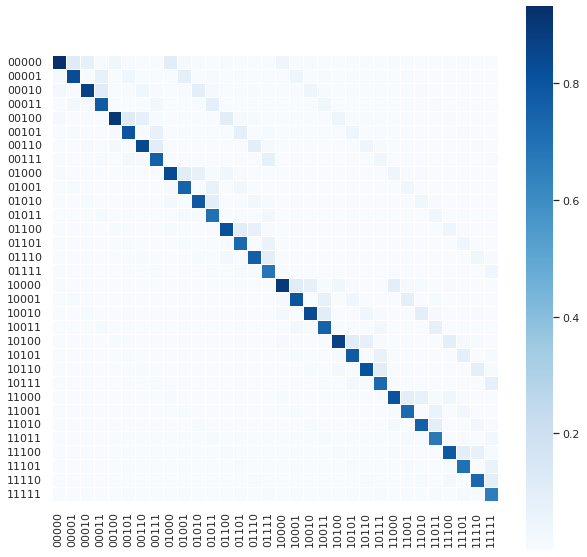

In [24]:
basis_state = get_basis_state(nqubit = 5)

import seaborn as sns
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(
    matrixG,
    cmap=sns.color_palette("Blues", as_cmap=True),
    linewidths=.5,
    xticklabels = basis_state,
    yticklabels = basis_state,
    square = True
)

## Appendix A: Validation of Code

In [25]:
getDenOper(rho0_GST)

array([[ 0.9945645+0.j, -0.0085467+0.j],
       [-0.0269976+0.j,  0.0054355+0.j]])

In [26]:
rho0

array([[ 0.9945645, -0.0085467],
       [-0.0269976,  0.0054355]])